In [1]:
import glob
from io import BytesIO
from pathlib import Path
import re
from urllib.parse import urljoin
from zipfile import ZipFile

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests

# Retrieve the latest baby names dataset
The full baby names dataset is available from the SSA's website as three zip files.
https://www.ssa.gov/oact/babynames/limits.html

* National data
* State-specific data
* Territory-specific data

In [2]:
limits_url = 'https://www.ssa.gov/oact/babynames/limits.html'
r = requests.get(limits_url)
r.raise_for_status()
bs = BeautifulSoup(r.content, 'html5lib')

In [3]:
zips = {}
Path('data').mkdir(exist_ok=True)
!rm -f data/*
for a in bs.find_all('a', {'href': lambda x: x.endswith('.zip')}):
    zip_url = urljoin(limits_url, a['href'])
    r = requests.get(zip_url)
    r.raise_for_status()
    with ZipFile(BytesIO(r.content)) as archive:
        archive.extractall('data')

In [4]:
!ls data

PR.TXT	      StateReadMe.pdf	   yob1905.txt	yob1945.txt  yob1985.txt
STATE.AK.TXT  STATE.RI.TXT	   yob1906.txt	yob1946.txt  yob1986.txt
STATE.AL.TXT  STATE.SC.TXT	   yob1907.txt	yob1947.txt  yob1987.txt
STATE.AR.TXT  STATE.SD.TXT	   yob1908.txt	yob1948.txt  yob1988.txt
STATE.AZ.TXT  STATE.TN.TXT	   yob1909.txt	yob1949.txt  yob1989.txt
STATE.CA.TXT  STATE.TX.TXT	   yob1910.txt	yob1950.txt  yob1990.txt
STATE.CO.TXT  STATE.UT.TXT	   yob1911.txt	yob1951.txt  yob1991.txt
STATE.CT.TXT  STATE.VA.TXT	   yob1912.txt	yob1952.txt  yob1992.txt
STATE.DC.TXT  STATE.VT.TXT	   yob1913.txt	yob1953.txt  yob1993.txt
STATE.DE.TXT  STATE.WA.TXT	   yob1914.txt	yob1954.txt  yob1994.txt
STATE.FL.TXT  STATE.WI.TXT	   yob1915.txt	yob1955.txt  yob1995.txt
STATE.GA.TXT  STATE.WV.TXT	   yob1916.txt	yob1956.txt  yob1996.txt
STATE.HI.TXT  STATE.WY.TXT	   yob1917.txt	yob1957.txt  yob1997.txt
STATE.IA.TXT  TerritoryReadMe.pdf  yob1918.txt	yob1958.txt  yob1998.txt
STATE.ID.TXT  TR.TXT		   yob1919.txt	yob1959.txt  yob19

Note that the latest national year-of-birth file is for 2019.

# Process the national data
We will load each national year-of-birth files, add columns for 

* the year (since this is implicit in the YOB file names), and
* the popularity rank of the name for the year. 

Then concatenate all the yearly data into a single table.

In [5]:
data = pd.DataFrame([], columns=['name', 'sex', 'count', 'rank', 'year'])
for filename in glob.glob('data/yob*.txt'):
    df = pd.read_csv(filename, header=None, names=["name", "sex", "count"])
    df['year'] = int(*re.findall(r'(\d+)', filename))
    df.loc[df['sex']=='F','rank'] = df.loc[df['sex']=='F','count'].rank(axis=0, method='min', ascending=False)
    df.loc[df['sex']=='M','rank'] = df.loc[df['sex']=='M','count'].rank(axis=0, method='min', ascending=False)
    data = pd.concat([data, df], sort=False)

In [6]:
data['rank'] = data['rank'].astype(int)

In [7]:
data.tail()

,name,sex,count,rank,year
3086,Worley,M,5,1101,1896
3087,Wright,M,5,1101,1896
3088,Xavier,M,5,1101,1896
3089,York,M,5,1101,1896
3090,Zollie,M,5,1101,1896


In [8]:
data = data.set_index(['name', 'year', 'sex']).unstack().unstack()

In [9]:
def plot_count(name, sex):
    return data.loc[name,:]['count'][sex].plot(
        grid=True, figsize=(10,10),
        title=('Boys' if sex == 'M' else 'Girls') + ' named ' + name)

In [10]:
def plot_rank(name, sex):
    plot = data.loc[name,:]['rank'][sex].plot(
        grid=True, figsize=(10,10),
        title='Popularity rank of ' + name + ' for ' + 
        ('Boys' if sex == 'M' else 'Girls'))
    plot.invert_yaxis()
    return plot

<AxesSubplot:title={'center':'Popularity rank of Eve for Girls'}, xlabel='year'>

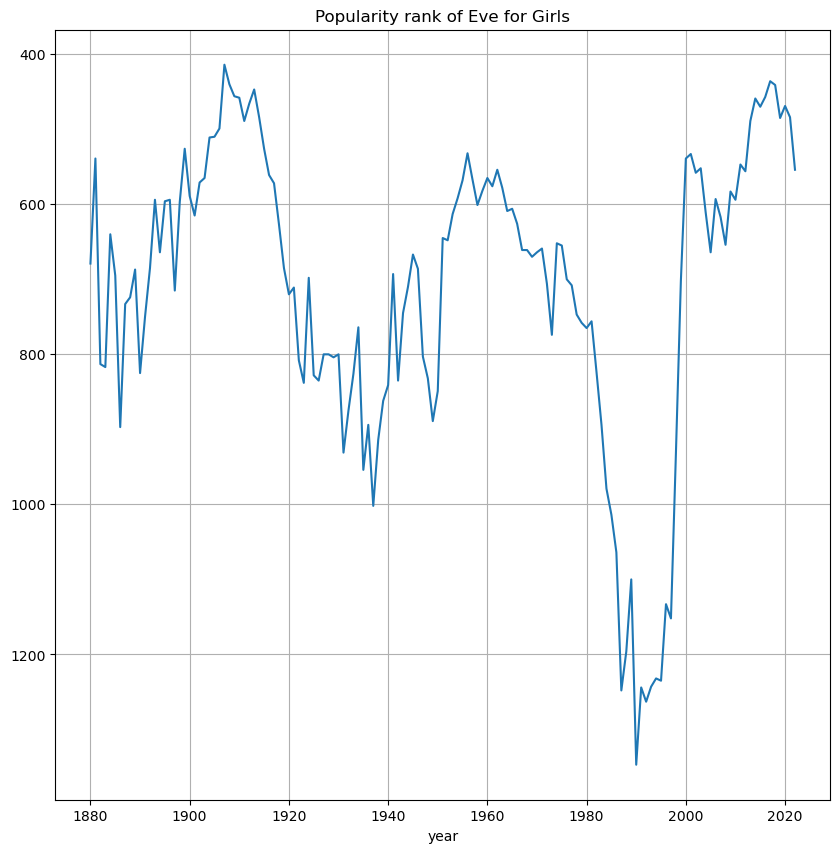

In [11]:
plot_rank('Eve', 'F')

<AxesSubplot:title={'center':'Popularity rank of Liam for Boys'}, xlabel='year'>

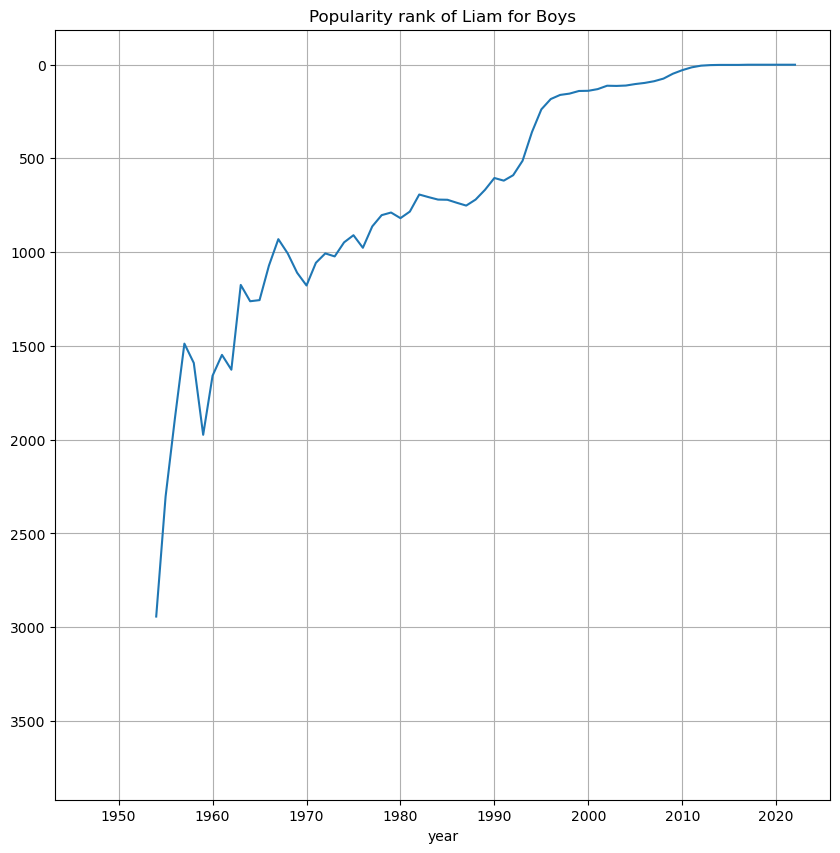

In [12]:
plot_rank('Liam', 'M')

<AxesSubplot:title={'center':'Boys named Liam'}, xlabel='year'>

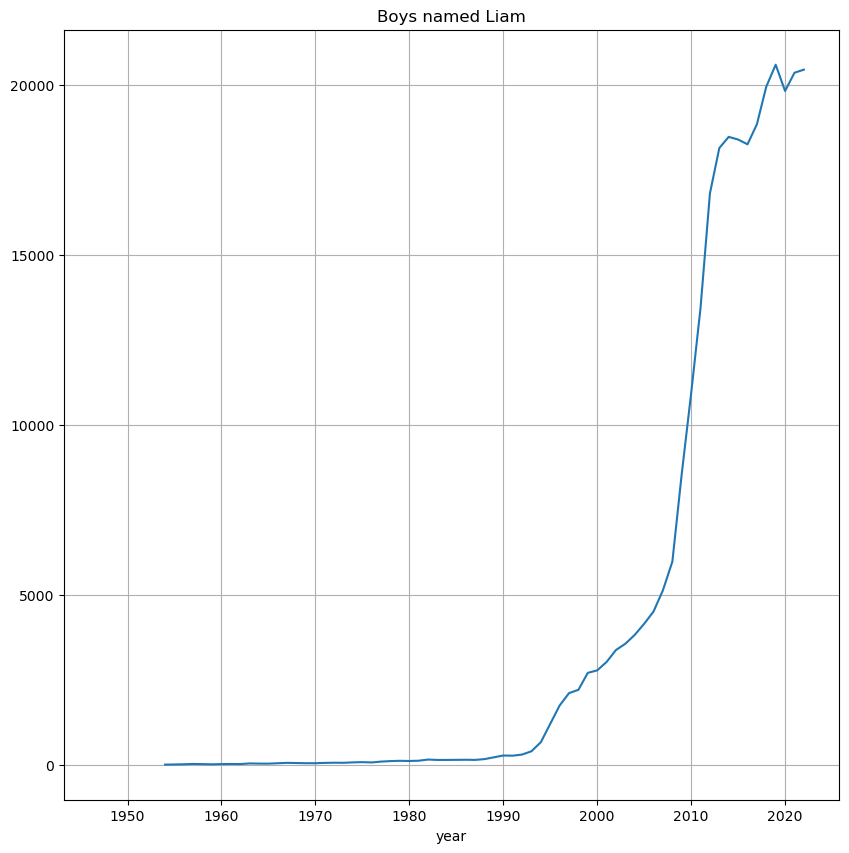

In [13]:
plot_count('Liam', 'M')

<AxesSubplot:title={'center':'Boys named Xander'}, xlabel='year'>

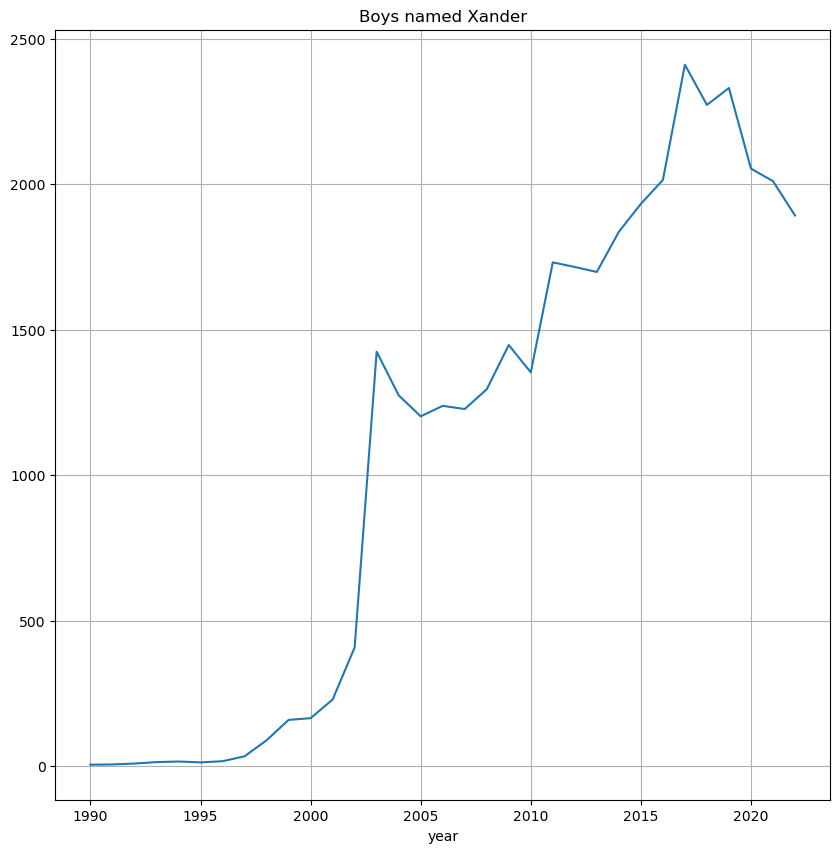

In [14]:
plot_count('Xander', 'M')

<AxesSubplot:title={'center':'Popularity rank of Xander for Boys'}, xlabel='year'>

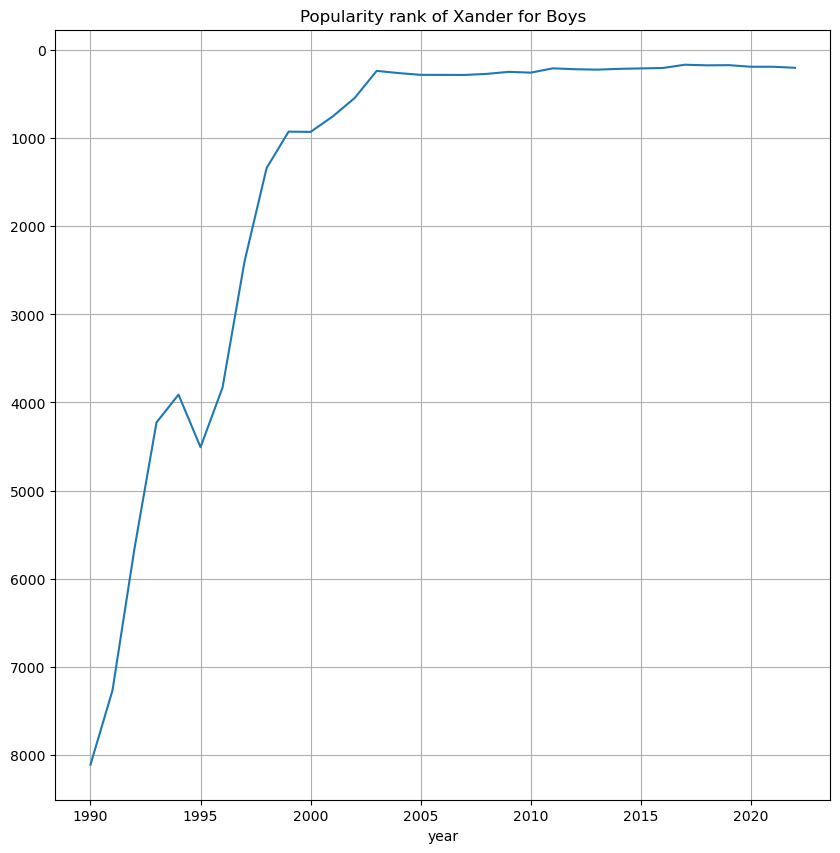

In [15]:
plot_rank('Xander', 'M')

(1980.0, 2021.0)

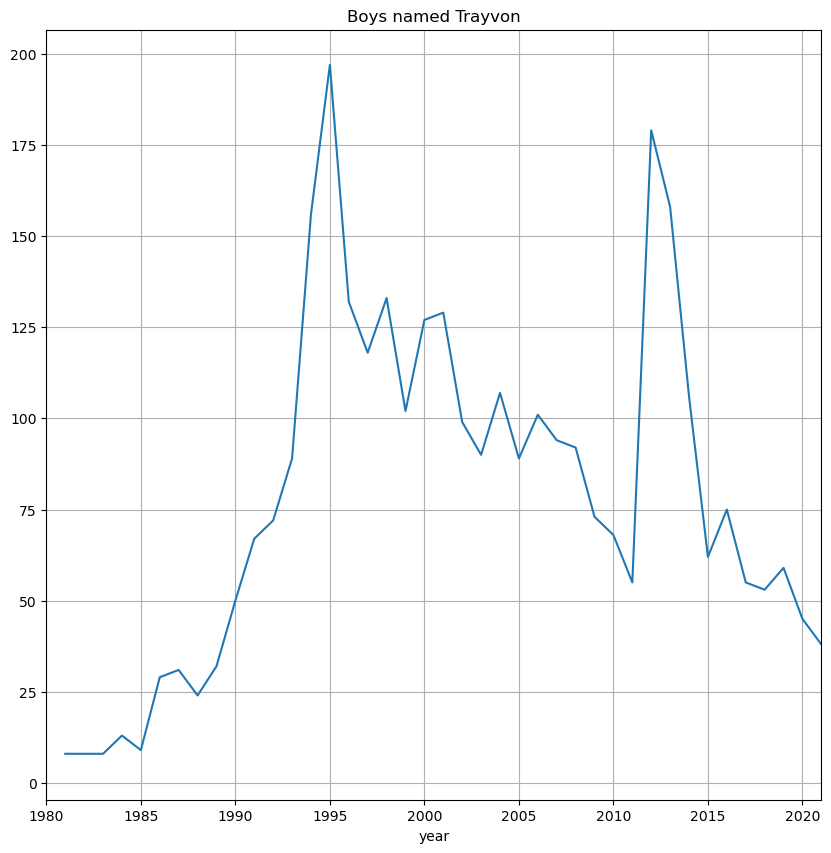

In [16]:
plot_count('Trayvon', 'M')
plt.xlim((1980,2021))

(1980.0, 2021.0)

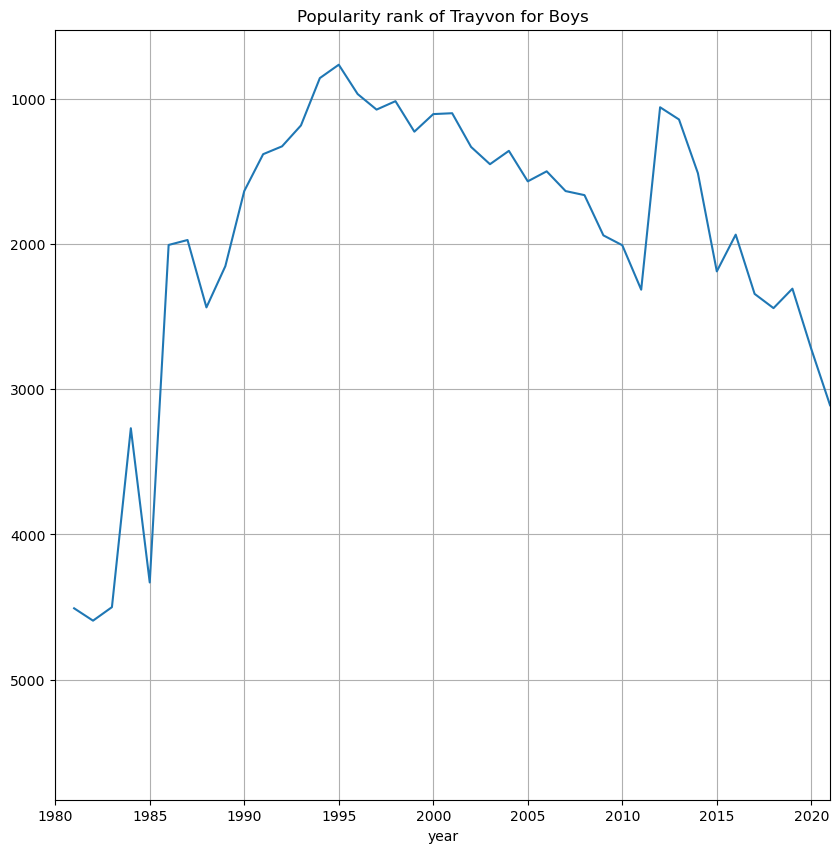

In [17]:
plot_rank('Trayvon', 'M')
plt.xlim((1980,2021))

## Write the data to CSV file

In [18]:
data.stack().stack().reset_index()[['name','sex','year','rank','count']].sort_values(
    ['rank','year']
).to_csv(
    'names_ranks_counts.csv', 
    index=False
)

# Process state data

In [23]:
state_data = pd.DataFrame([], columns=['state', 'sex', 'year', 'name', 'count', 'rank'])
for filename in glob.glob('data/STATE.[A-Z][A-Z].*') + ['data/PR.TXT', 'data/TR.TXT']:
    df = pd.read_csv(filename, header=None, names=['state', 'sex', 'year', 'name', 'count'])
    for (year, sex), group in df.groupby(['year', 'sex'], sort=False):
        df.loc[group.index,'rank'] = group['count'].rank(axis=0, method='min', ascending=False)
    df.loc[:,'rank'] = df['rank'].astype(int)
    state_data = pd.concat([state_data, df])

## Write the data to CSV file

In [24]:
state_data.shape

(6434925, 6)

In [25]:
state_data['rank'] = state_data['rank'].astype(int)
state_data.sort_values(
    ['state', 'year', 'rank']
).to_csv(
    'namesbystate_ranks_counts.csv',
    index=False
)